In [1]:
import fedhex as fx
from matplotlib import pyplot as plt
import numpy as np

In [2]:
root_path = "./root/10x10box_10k_jun2023/"
rl = fx.RootLoader(path=root_path)

In [3]:
thresh = 150
samples, labels = rl.load(event_thresh=thresh)

13:47:17.04 <W> --- ./root/10x10box_10k_jun2023//Phi_1870_omega_9p025/2023-06-
12-11-54-06/v1p0-78-8cf4/ATTOAODv1p2c2_0.root: empty file ---


In [4]:
data, cond = rl.preproc()

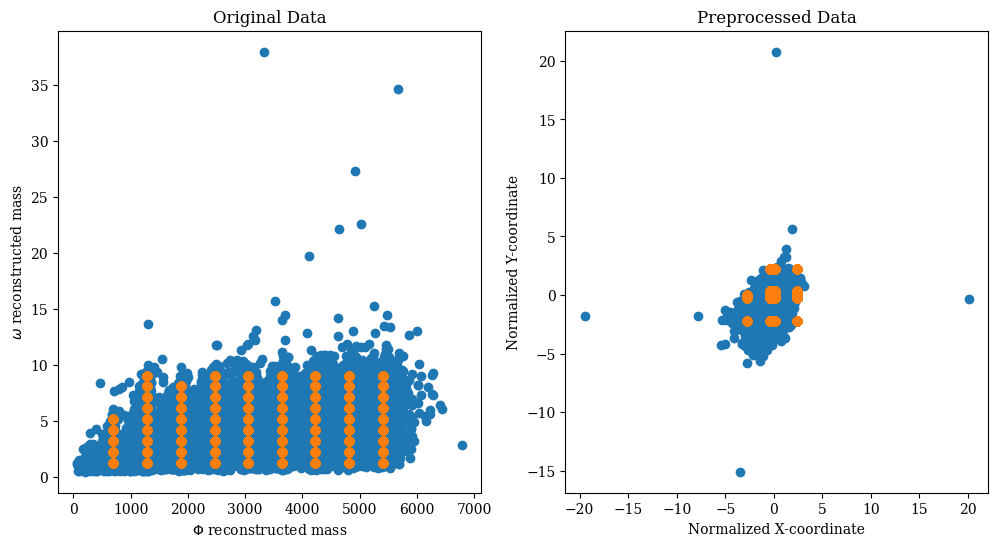

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.scatter(samples[:,0], samples[:,1])
ax1.scatter(labels[:,0], labels[:,1])
ax1.set_title("Original Data")
ax1.set_xlabel(r"$\Phi$ reconstructed mass")
ax1.set_ylabel(r"$\omega$ reconstructed mass")

ax2.scatter(data[:,0], data[:,1])
ax2.scatter(cond[:,0], cond[:,1])
ax2.set_title("Preprocessed Data")
ax2.set_xlabel("Normalized X-coordinate")
ax2.set_ylabel("Normalized Y-coordinate")
pass

In [6]:
nmade = 10
ninputs = 2
ncinputs = 2
hidden_layers = 1
hidden_units = 128
lr_tuple = (1e-3, 1e-4, 100)
mm = fx.MADEManager(nmade=nmade, ninputs=ninputs, ncinputs=ncinputs,
                    hidden_layers=hidden_layers, hidden_units=hidden_units,
                    lr_tuple=lr_tuple)

In [7]:
mm.compile_model()

In [8]:
starting_epoch = 0
end_epoch = 200
batch_size = 1024
flow_path = "./model/08-24_tut_root/"
loss_path = flow_path + "loss.npy"

In [9]:
from fedhex.train import Checkpointer, EpochLossHistory, SelectiveProgbarLogger

callbacks = []

save_freq = 50 * batch_size
callbacks.append(Checkpointer(filepath=flow_path, save_freq=save_freq))

callbacks.append(EpochLossHistory(loss_path=loss_path))

log_freq = 10
callbacks.append(SelectiveProgbarLogger(1, epoch_interval=log_freq, epoch_end=end_epoch))

In [10]:
mm.train_model(data=data, cond=cond, batch_size=batch_size,
               starting_epoch=starting_epoch, end_epoch=end_epoch,
               path=flow_path, callbacks=callbacks)

13:47:24.40 <I> [Training begins]


2023-08-31 13:47:24.434303: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


epoch begin: 2023-08-31 13:47:36.254233 | time elapsed: 0:00:11.821338
Epoch 10/200
47/47 [==============================] - 1s 22ms/sample - loss: 2.0969
epoch begin: 2023-08-31 13:47:45.913087 | time elapsed: 0:00:21.480192
Epoch 20/200
47/47 [==============================] - 1s 21ms/sample - loss: 0.9923
epoch begin: 2023-08-31 13:47:55.580148 | time elapsed: 0:00:31.147253
Epoch 30/200
47/47 [==============================] - 1s 21ms/sample - loss: 0.4977
epoch begin: 2023-08-31 13:48:05.403697 | time elapsed: 0:00:40.970802
Epoch 40/200
47/47 [==============================] - 1s 21ms/sample - loss: 0.2159
epoch begin: 2023-08-31 13:48:15.142832 | time elapsed: 0:00:50.709937
Epoch 50/200
47/47 [==============================] - 1s 21ms/sample - loss: 0.0655
epoch begin: 2023-08-31 13:48:24.904058 | time elapsed: 0:01:00.471163
Epoch 60/200
47/47 [==============================] - 1s 21ms/sample - loss: -0.0291
epoch begin: 2023-08-31 13:48:34.788692 | time elapsed: 0:01:10.35579

INFO:tensorflow:Assets written to: ./model/08-24_tut_root/assets


INFO:tensorflow:Assets written to: ./model/08-24_tut_root/assets


13:50:50.44 <I> [Training ends]
0:03:26.03 <I> [Time elapsed]


In [11]:
ngen = 500
gen_labels_unique = [2464., 5.125]
gen_labels = np.repeat([gen_labels_unique], ngen, axis=0)
gen_cond = rl.norm(gen_labels, is_cond=True)

In [12]:
gen_data = mm.eval_model(gen_cond)

In [13]:
gen_samples = rl.denorm(gen_data, is_cond=False)

/Users/darshan/Desktop/Research/flows_pseudoaxions/fedhex/pretrain/_data.py:99: RuntimeWarning: overflow encountered in exp
  data_unit = 1 / (1 + np.exp(-data_logit))


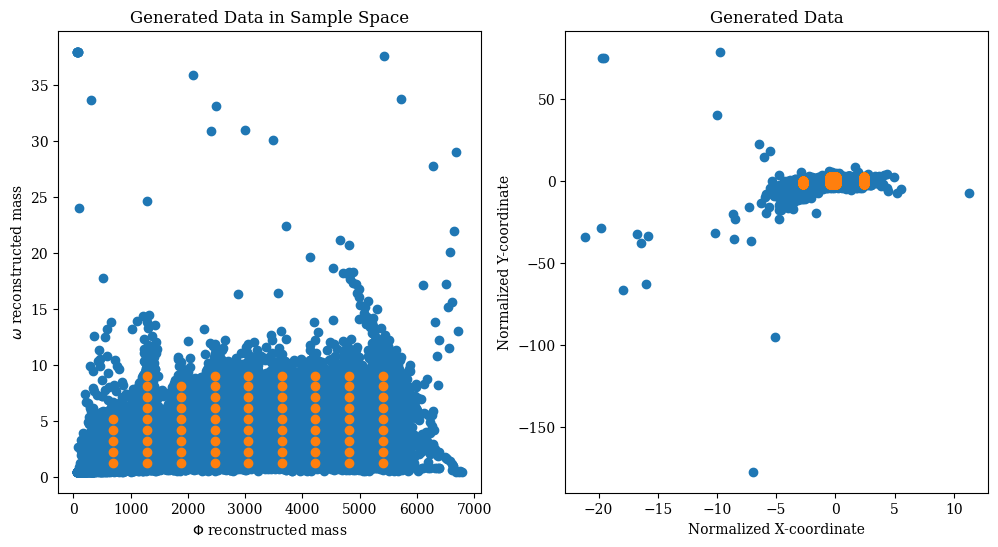

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.scatter(gen_samples[:,0], gen_samples[:,1])
ax1.scatter(gen_labels_unique[0], gen_labels_unique[1])
ax1.set_title("Generated Data in Sample Space")
ax1.set_xlabel(r"$\Phi$ reconstructed mass")
ax1.set_ylabel(r"$\omega$ reconstructed mass")

ax2.scatter(gen_data[:,0], gen_data[:,1])
ax2.scatter(gen_cond[:,0], gen_cond[:,1])
ax2.set_title("Generated Data")
ax2.set_xlabel("Normalized X-coordinate")
ax2.set_ylabel("Normalized Y-coordinate")
pass

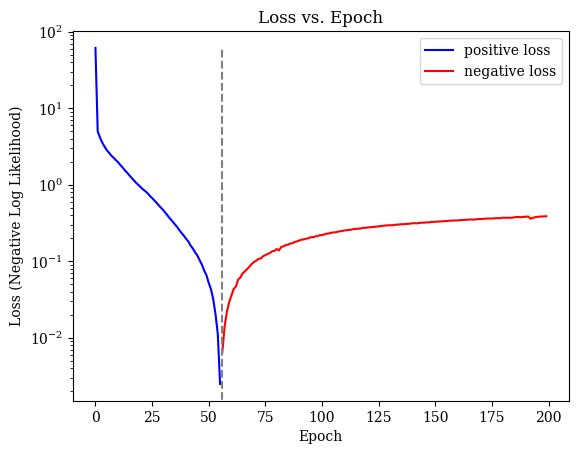

In [15]:
from fedhex.posttrain import plot as fxp
fxp.plot_losses(np.load(loss_path), show=True)

In [16]:
#Save output to a ROOT or npy file. Training data ("trn_data", "trn_cond") is optional
output_path = "./output/08-24-tut_root/"
npy_path = output_path + "npy/npy_out.npy"
root_out_path = output_path + "root/root_out.ROOT"

saver = fx.Loader(data_dict={"gen_samples": gen_samples, "gen_labels": gen_labels, "trn_samples": samples, "trn_labels": labels})

saver.save_to_root(root_out_path)
saver.save_to_npy(npy_path)
